In [176]:
from matplotlib import rcParams
import torch
from typing import Any, List, Sequence, Union
import yaml

# Local imports
from Utils.Types.Grid import construct_grid, Grid
from Utils.Types.DataSet import DataSet
from Utils.functions import f, integrate, u, test_function
import Utils.plots as plots
from Utils.utils import validate_cfg
from Utils.VPINN import VPINN

In [177]:
# Specify device used to train. Default is the gpu, but torch falls back on the cpu in case cuda is unavailable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [178]:
# Load config file
with open('config.yml', 'r') as file:
    cfg = yaml.safe_load(file)

In [179]:
# Validate the configuration to prevent cryptic errors
validate_cfg(cfg)

# Get space parameters from the config
dim: int = cfg['space']['dimension']
eq_type: str = cfg['PDE']['type']
var_form: int = cfg['variational_form']
grid_size: Union[int, Sequence[int]] = cfg['space']['grid_size']['x'] if dim == 1 else [cfg['space']['grid_size']['x'], cfg['space']['grid_size']['y']]
grid_boundary: Sequence = cfg['space']['boundary']['x'] if dim == 1 else [cfg['space']['boundary']['x'], cfg['space']['boundary']['y']]

# Get the neural net architecture from the config
n_nodes: int = cfg['architecture']['nodes_per_layer']
n_layers: int = cfg['architecture']['layers']
architecture: Union[List[int], Any] = [dim] + [n_nodes] * (n_layers+1) + [1]

# Get PDE constants from the config
PDE_constants: dict = {'Helmholtz': cfg['PDE']['Helmholtz']['k'],
                       'Burger': cfg['PDE']['Burger']['nu']}

# Get number of test functions used
n_test_func: int = cfg['N_test_functions']

In [180]:
# Construct the grid
print("Constructing grid ...")
grid: Grid = construct_grid(dim, grid_boundary, grid_size, as_tensor=True, requires_grad=False)

Constructing grid ...


In [181]:
# Evaluate the test functions on grid points. This only needs to be done once.
print("Evaluating test functions on the grid interior ... ")
test_func_vals: DataSet = DataSet(coords=[[i] for i in range(n_test_func)],
                                  data=[test_function(grid.data, i) for i in range(1, n_test_func + 1)],
                                  as_tensor=True, requires_grad=False)

Evaluating test functions on the grid interior ... 


In [182]:
# Integrate the external function over the grid against all the test functions.
# This will be used to calculate the variational loss and only needs to be done once.
print("Integrating test functions ...")
f_integrated: DataSet = DataSet(coords=[[i] for i in range(n_test_func)],
                                data=[integrate(f(grid.data), test_func_vals.data[i])
                                      for i in range(n_test_func)],
                                as_tensor=True, requires_grad=False)

Integrating test functions ...


In [183]:
# Instantiate the model class
model: VPINN = VPINN(architecture, eq_type, var_form,
                     pde_constants=PDE_constants,
                     learning_rate=cfg['learning_rate'],
                     activation_func=torch.sin).to(device)

In [184]:
# Turn on tracking for the grid
# Note: this actually only needs to happen for the domain of integration (in our case the interior)
grid.data.requires_grad = True
grid.interior.requires_grad = True
grid.boundary.requires_grad = True

In [185]:
# Prepare the training data. The training data consists of the explicit solution of the function on the boundary
print("Generating training data ...")
training_data: DataSet = DataSet(coords=grid.boundary, data=u(grid.boundary), as_tensor=True, requires_grad=False)

Generating training data ...


In [186]:
# Train the model
print("Commencing training ...")
loss_w: float = cfg['loss_weight']
model.reset_loss_tracker()
for it in range(cfg['N_iterations']+1):

    model.optimizer.zero_grad()

    # Calculate the loss
    loss_b = model.boundary_loss(training_data)
    loss_v = model.variational_loss(grid, f_integrated, test_func_vals)
    loss = loss_b + loss_w * loss_v
    loss.backward(retain_graph=True)

    # Adjust the model parameters
    model.optimizer.step()

    # Track loss values
    loss_glob, loss_b_glob, loss_v_glob = loss.item(), loss_b.item(), loss_v.item()

    if it % 10 == 0:
        model.update_loss_tracker(it, loss_glob, loss_b_glob, loss_v_glob)
    if it % 100 == 0:
        print(f"Iteration {it}: total loss: {loss_glob}, loss_b: {loss_b_glob}, loss_v: {loss_v_glob}")

print("Training complete.")

Commencing training ...
Iteration 0: total loss: 0.10721790790557861, loss_b: 0.01845249906182289, loss_v: 0.8876540064811707
Iteration 100: total loss: 0.08874505013227463, loss_b: 2.317396592843579e-06, loss_v: 0.8874273300170898
Iteration 200: total loss: 0.08868704736232758, loss_b: 9.38478024181677e-06, loss_v: 0.8867765665054321
Iteration 300: total loss: 0.08547843247652054, loss_b: 0.0006620461354032159, loss_v: 0.848163902759552
Iteration 400: total loss: 0.05847601220011711, loss_b: 0.011970593594014645, loss_v: 0.4650541841983795
Iteration 500: total loss: 0.05030648410320282, loss_b: 0.006845671217888594, loss_v: 0.43460813164711
Iteration 600: total loss: 0.04495931416749954, loss_b: 0.005900172051042318, loss_v: 0.39059144258499146
Iteration 700: total loss: 0.03168848901987076, loss_b: 0.0049051144160330296, loss_v: 0.26783373951911926
Iteration 800: total loss: 0.02090257965028286, loss_b: 0.003418734995648265, loss_v: 0.17483845353126526
Iteration 900: total loss: 0.01

In [187]:
# Plot the results
rcParams.update(cfg['plots']['rcParams'])

# Generate the plot grid, which may be finer than the training grid
plot_res = cfg['plots']['plot_resolution']['x'] if dim == 1 else [cfg['plots']['plot_resolution']['x'], cfg['plots']['plot_resolution']['y']]
plot_grid: Grid = construct_grid(dim, grid_boundary, plot_res, requires_grad=False)
    
 # Get the model predictions on the plotting grid. Turn off tracking for the prediction data.
predictions = model.forward(plot_grid.data).detach()

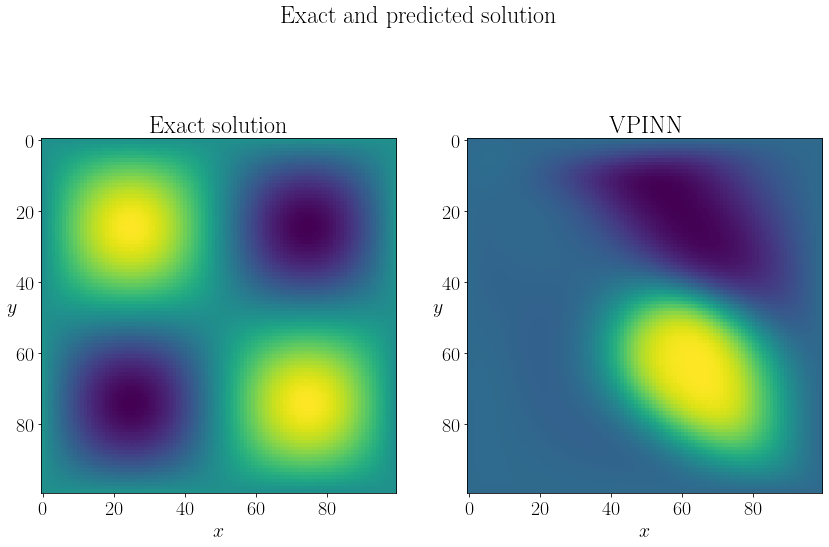

In [188]:
# Plot predicted vs actual values
plots.plot_prediction(plot_grid, predictions, grid_shape=plot_res)

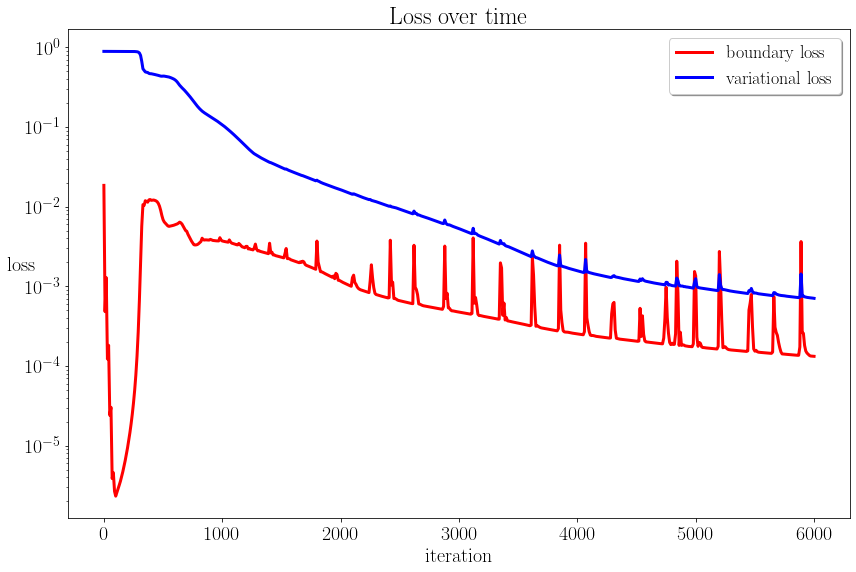

In [189]:
# Plot loss over time
plots.plot_loss(model.loss_tracker)

In [190]:
print(training_data.data)

tensor([[ 1.4998e-32],
        [ 3.9764e-17],
        [ 7.5219e-17],
        [ 1.0252e-16],
        [ 1.1872e-16],
        [ 1.2205e-16],
        [ 1.1215e-16],
        [ 9.0100e-17],
        [ 5.8287e-17],
        [ 2.0157e-17],
        [-2.0157e-17],
        [-5.8287e-17],
        [-9.0100e-17],
        [-1.1215e-16],
        [-1.2205e-16],
        [-1.1872e-16],
        [-1.0252e-16],
        [-7.5219e-17],
        [-3.9764e-17],
        [-1.4998e-32],
        [ 3.9764e-17],
        [-3.9764e-17],
        [ 7.5219e-17],
        [-7.5219e-17],
        [ 1.0252e-16],
        [-1.0252e-16],
        [ 1.1872e-16],
        [-1.1872e-16],
        [ 1.2205e-16],
        [-1.2205e-16],
        [ 1.1215e-16],
        [-1.1215e-16],
        [ 9.0100e-17],
        [-9.0100e-17],
        [ 5.8287e-17],
        [-5.8287e-17],
        [ 2.0157e-17],
        [-2.0157e-17],
        [-2.0157e-17],
        [ 2.0157e-17],
        [-5.8287e-17],
        [ 5.8287e-17],
        [-9.0100e-17],
        [ 9